# Classifying EEG wave for Sleep scoring

L'objectif est de prédire l'état de sommeil d'un individu en fonction des ondes électriques générées par son cerveau. Plus précisément il s'agit de labelliser automatiquement des échantillons de 30s de données d'électroencephalographie (EEG) en fonction du stade de sommeil durant lequel elles ont été enregistrées.

In [31]:
import numpy as np
import pandas as pd
import pywt as pywt
from scipy import stats
from scipy import io

import numpy as np
import pandas as pd
from loadAndCreateFeatures import (loadData,featureCreation,windowing2)
from sklearn.svm import SVC
from extractFeaturesSource import normalize,dataTransform,normalizeTest

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()

In [33]:
X_train,y_train,X_test = loadData()
dico = {'W ':0,'N1':1,'N2':2,'N3':3,'R ':4}
y_train_np=np.array([dico[y] for y in y_train])

Voyons dans un premier temps, la representation temporel des ondes.

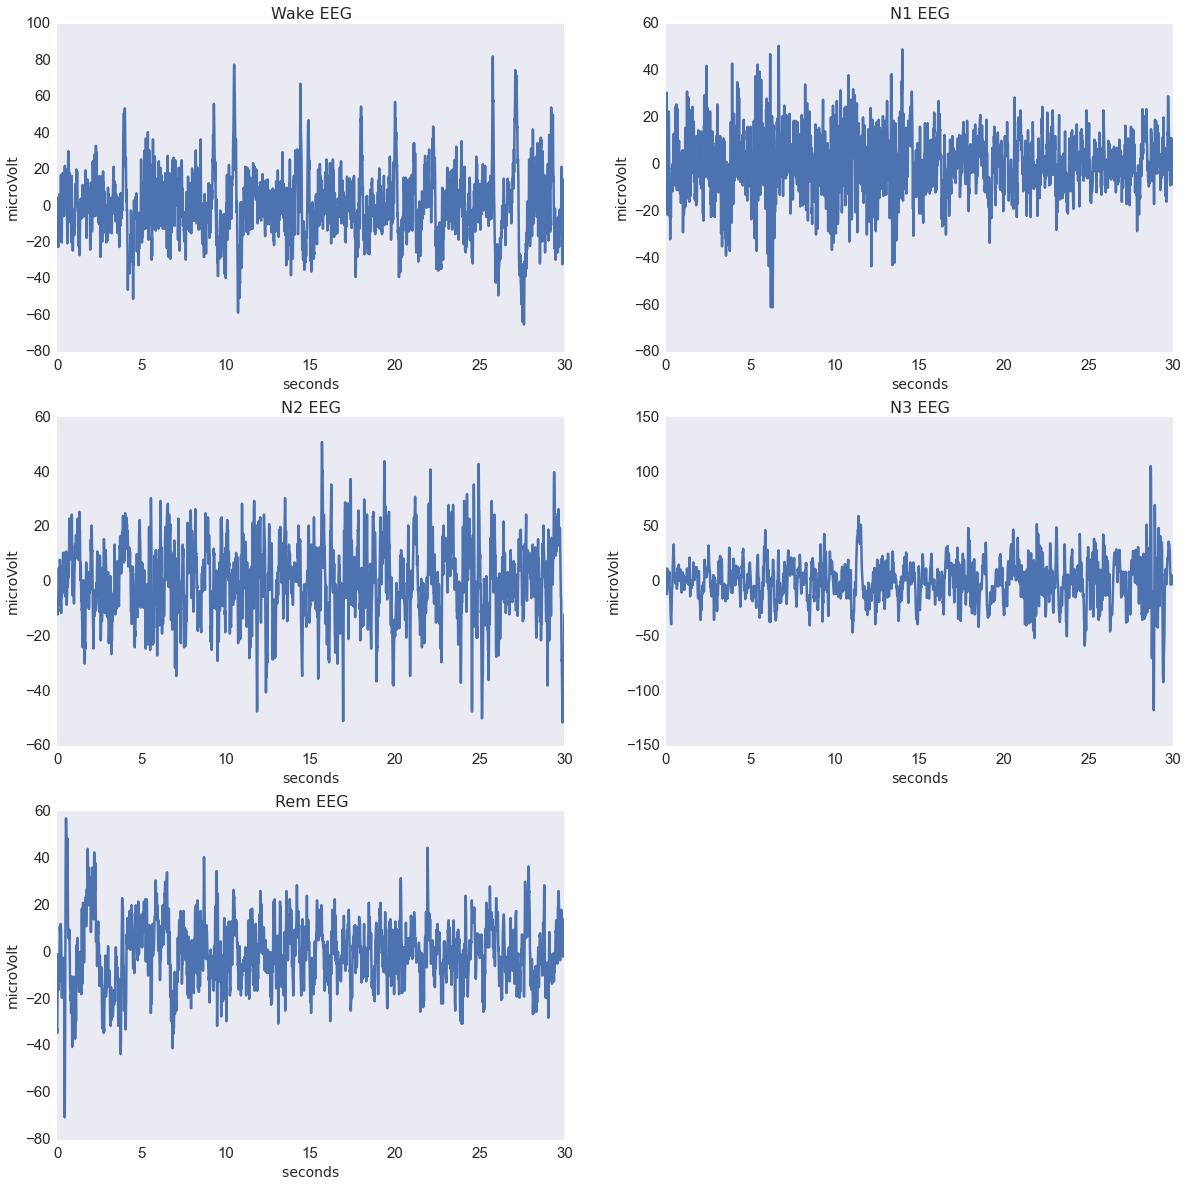

In [36]:
t=np.linspace(0,30,6000)
plt.figure(1,figsize=(20,20))
plt.subplot(321)
plt.plot(t,X_train[y_train=='W '][0])
plt.xlabel("seconds\n",fontsize=14)
plt.ylabel("microVolt",fontsize=14)
plt.title("Wake EEG",fontsize=16)
plt.subplot(322)
plt.plot(t,X_train[y_train=='N1'][0])
plt.xlabel("seconds\n",fontsize=14)
plt.ylabel("microVolt",fontsize=14)
plt.title("N1 EEG",fontsize=16)
plt.subplot(323)
plt.plot(t,X_train[y_train=='N2'][1])
plt.xlabel("seconds\n",fontsize=14)
plt.ylabel("microVolt",fontsize=14)
plt.title("N2 EEG",fontsize=16)
plt.subplot(324)
plt.plot(t,X_train[y_train=='N3'][0])
plt.xlabel("seconds\n",fontsize=14)
plt.ylabel("microVolt",fontsize=14)
plt.title("N3 EEG",fontsize=16)
plt.subplot(325)
plt.plot(t,X_train[y_train=='R '][0])
plt.xlabel("seconds \n",fontsize=14)
plt.ylabel("microVolt",fontsize=14)
plt.title("Rem EEG",fontsize=16)
plt.savefig('eegimage.pdf')

Nous devons dans un premier temps extraire des 'features' à partir des signaux de trentres secondes.

## Extraction des features
### 1 FFT Features
Les transformées de Fourier vont nous permettre d'extraire une information sur l'amplitude des frequences présentes dans le signal. Pour cela nous utiliserons la fonction FFT de numpy. Nous definirons des bandes de frequences sgnificatives dans l'étude des EEG.
### 2 Wavelet Features
Les Wavelets sont utilisées pour décomposer le signal, soit en utilisant la version continue CWT avec la famille d’onde de Morlet, soit avec la version discrete DWT. La DWT permet de séparer les dif- férentes bandes de fréquences des EEG comme la transformée de Fourier mais permet d’avoir une evolution des fréquences du signal en fonction du temps. Quelques features supplementaires, notamment le zero-crossing, ainsi que la Willison amplitude WAMP, la Myopulse percentage rate (MYOP), Maximum Fractal Length (MFL), Waveform length (WL).
### 3 features sur le signal brut
quelques features sur le signal brut, notamment la kurtosis, la skewness ainsi que la variation d’amplitude moyenne
### 4 Pyrem Features
quelques features calculer en utilisant Univariate provenant de https://github.com/gilestrolab/pyrem

In [9]:
print 'extracting train features'
X_train_Df = featureCreation(X_train,4,30)

print 'extracting window 2 train features'
XW2,XW2_Df,y2t = windowing2(X_train,y_train_np)

X_train_DftN = normalize(dataTransform(X_train_Df))
XW2_DftN = normalize(dataTransform(XW2_Df))

extracting train features
extracting Features
extracting FFT features
extracting Wavelet features
extracting Global features
extracting Fractal features (slow)
extracting filtered features

extractFeaturesSource.py:354: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 6000 but corresponding boolean dimension is 5998
  compr = zlib.compress(s)
Univariate.py:104: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 761 but corresponding boolean dimension is 760
  Cm[inrange_last] += 1



extracting window 2 train features
Window creation
Window features extraction
extracting Features
extracting FFT features
extracting Wavelet features
extracting Global features
extracting Fractal features (slow)
extracting filtered features

extractFeaturesSource.py:354: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3500 but corresponding boolean dimension is 3498
  compr = zlib.compress(s)
Univariate.py:104: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 447 but corresponding boolean dimension is 446
  Cm[inrange_last] += 1


NameError: name 'XW2_DftN' is not defined

In [ ]:
print 'extracting test features'
X_test_Df = featureCreation(X_test,4,30)

print 'extracting window 2 test features'
XW2t,XW2t_Df,_ = windowing2(X_test,[])

X_test_DftN = normalizeTest(dataTransform(X_test_Df),dataTransform(X_train_Df))
XW2t_DftN = normalizeTest(dataTransform(XW2t_Df),dataTransform(XW2_Df))

##Features Selection

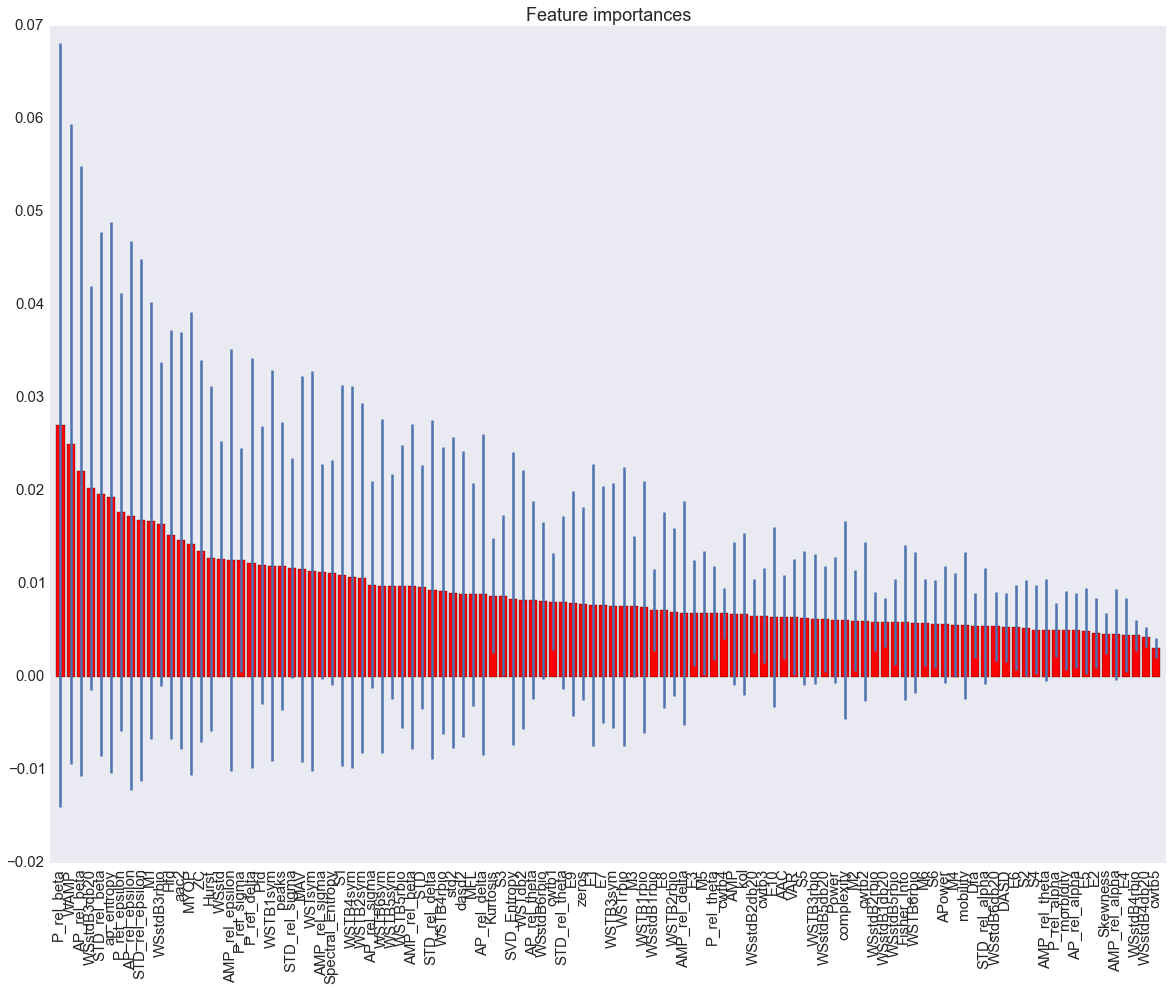

In [47]:
from featuresSelection import (greedy,featureSelection,plotImportance,createConfusionMatrix)
plotImportance(X_train_DftN,y_train_np)

Utilisons un algorithme greedy pour rajouter des features une a une.

In [ ]:
clf = SVC()
greedy(clf,X_train_DftN,y_train_np)

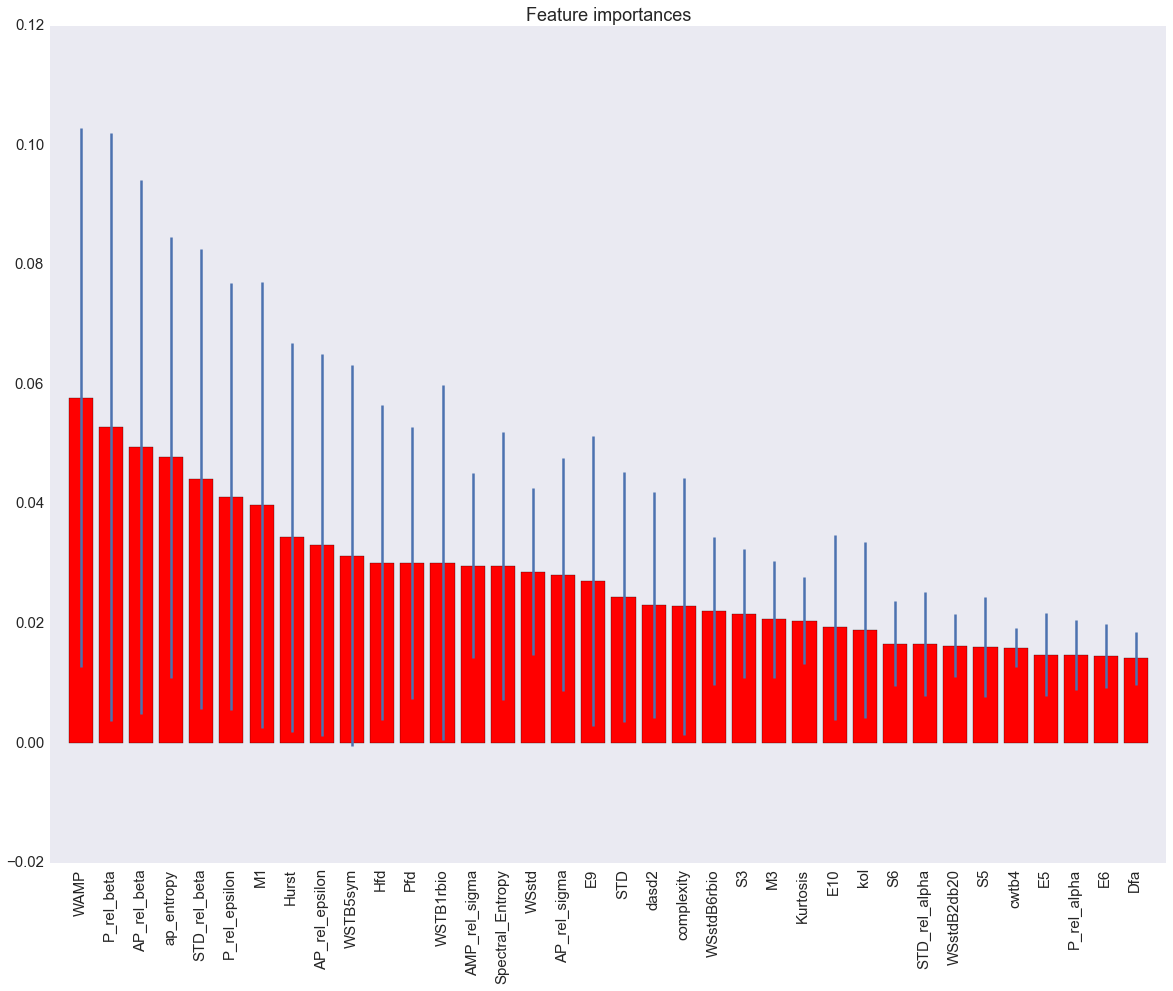

In [38]:
colx = (['P_rel_beta', 'WAMP', 'S6', 'STD_rel_beta', 'AMP_rel_sigma', 'Hfd', 'Kurtosis',
        'Hurst', 'Spectral_Entropy', 'AP_rel_sigma', 'P_rel_epsilon', 'dasd2', 'S3',
        'AP_rel_epsilon', 'E10', 'Dfa', 'STD', 'AP_rel_beta', 'E5', 'Pfd', 'ap_entropy',
        'P_rel_alpha', 'E9', 'M3', 'WSstd', 'M1', 'complexity', 'E6', 'S5', 'cwtb4',
        'kol', 'WSstdB6rbio', 'STD_rel_alpha', 'WSTB1rbio', 'WSstdB2db20', 'WSTB5sym'])
plotImportance(X_train_DftN[colx],y_train_np)

##Model Selection

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.lda import LDA
from sklearn.qda import QDA


names = ["Nearest Neighbors", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "LDA", "QDA"]
classifiers = [
    KNeighborsClassifier(10),
    SVC(gamma=0.01,C=8.0),
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(max_depth=15, n_estimators=70, max_features=30),
    AdaBoostClassifier(),
    LDA(),
    QDA()]

X, y = X_train_DftN[colx],y_train_np

X_train, X_test, y_train, y_test = X[:8000],X[8000:],y[:8000],y[8000:]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print name+" score:",score

Nearest Neighbors score: 0.724977043159
RBF SVM score: 0.765381083563
Decision Tree score: 0.652892561983
Random Forest score: 0.715335169881
AdaBoost score: 0.570247933884
LDA score: 0.754361799816
QDA score: 0.664370982553


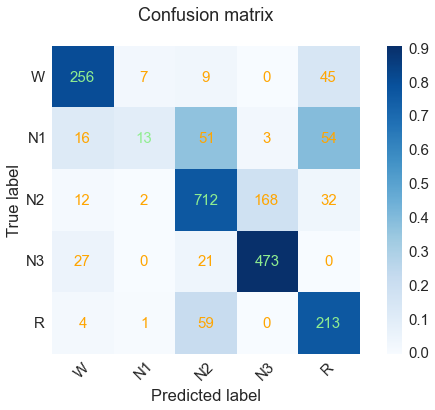

In [54]:
import imp
import featuresSelection
imp.reload(featuresSelection)
from featuresSelection import (greedy,featureSelection,plotImportance,createConfusionMatrix)
clf = SVC(gamma=0.01,C=8.0)
X_train, X_test, y_train, y_test = X[:8000],X[8000:],y[:8000],y[8000:]
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
createConfusionMatrix(pred,y_test)

## Solution

Apres avoir selectionné les features a l'aide d'un algorithme greedy et recherché les meta parametres des svm a l'aide d'une cross-validation. 

Il s'agit maintenant d'entrainer les modeles sur toutes les données pour soumettre une solution

In [ ]:
colx = (['P_rel_beta', 'WAMP', 'S6', 'STD_rel_beta', 'AMP_rel_sigma', 'Hfd', 'Kurtosis',
        'Hurst', 'Spectral_Entropy', 'AP_rel_sigma', 'P_rel_epsilon', 'dasd2', 'S3',
        'AP_rel_epsilon', 'E10', 'Dfa', 'STD', 'AP_rel_beta', 'E5', 'Pfd', 'ap_entropy',
        'P_rel_alpha', 'E9', 'M3', 'WSstd', 'M1', 'complexity', 'E6', 'S5', 'cwtb4',
        'kol', 'WSstdB6rbio', 'STD_rel_alpha', 'WSTB1rbio', 'WSstdB2db20', 'WSTB5sym'])

col2x = (['P_rel_beta', 'ap_entropy', 'peaks', 'AMP_rel_sigma', 'P_rel_epsilon', 'Hurst',
          'Spectral_Entropy', 'WSstdB3db20', 'Kurtosis', 'WAMP', 'AP_rel_sigma', 'WSstdB5rbio',
          'AP_rel_beta', 'STD', 'dasd2', 'E5', 'WSTB6sym', 'STD_rel_epsilon', 'cwtb4',
          'Hfd', 'WSTB2rbio'])

SVCt = SVC(gamma=0.0071000,C = 5.674999)
SVCt.fit(X_train_DftN[colx],y_train_np)
predict=np.array(SVCt.predict(X_test_DftN[colx]))
SVCt2 = SVC(C= 9.0, gamma= 0.00800)
SVCt2.fit(XW2_DftN[col2x],y2t)
predict2=np.array(SVCt2.predict(XW2t_DftN[col2x]))
n=len(predict)
t1 = np.array([i%2==0 for i in range(2*n)])
t2 = np.array([i%2==1 for i in range(2*n)])

result_Df = pd.DataFrame(predict,columns=['all'])
result_Df['t1']=predict2[t1]
result_Df['t2']=predict2[t2]

def majorityVote(line):
    res=np.zeros(5)
    res[line['all']] = 1
    res[line['t1']] = 0.5
    res[line['t2']] = 0.5
    return np.argmax(res)

result_Df['vote2'] = result_Df.apply(lambda x : majorityVote(x),axis=1)